## Statistic-Focused Fitting
> Example driven review and analysis fo how fitting model to a specific selection of phenomena helps clarify model limitations. Useful for establishing that model can or cannot account for the considered effect in principle. But limited, even in aggregate, as measure of overall performance.

> When fitting across an array of phenomena results in a poor account of one or more of them, it's possible to systematically sleuth for more specific tension-points in our model by fitting the model to each possible combination of 1 or more phenomena in the array, effectively isolating the patterns proving problematic for the model. This approach identifies patterns cannot account for individually, but also those it can account for only when at least one other relevant pattern is ignored.  Demo-driven explanation again using the PFR plateau. Make sure to emphasize core limitation: if we haven't characterized a pattern, we can isolate a tension! How do we sleuth for patterns in model limitations? 

## Setup

In [1]:
#| code-summary: code -- load dependencies and data

from compmemlearn.models import Classic_CMR
from compmemlearn.fitting import apply_and_concatenate
from compmemlearn.datasets import prepare_murdock1970_data
from compmemlearn.datasets import simulate_array, simulate_df
from compmemlearn.analyses import plot_spc, plot_lag_crp, plot_pfr
from compmemlearn.analyses import fast_spc, fast_crp, fast_pfr, fast_csp
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit, literal_unroll, prange
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

simulate_data = simulate_df

warnings.filterwarnings('ignore', 'First-class function type feature is experimental')

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data(
    '../../data/mo1970.txt')

In [2]:
@njit(nogil=True)
def murdock_mse(
    data_to_fit, item_counts, statistics, model_class, parameters):
    pooled_result = 0.0
    for i in range(len(item_counts)):
        
        # configure model
        item_count = item_counts[i]
        trials = data_to_fit[i]
        model = model_class(item_count, item_count, parameters)
        
        # generate simulation data from model
        sim_trials = simulate_array(model, len(trials)*10)
        
        # collect MSE for each relevant statistic
        result = 0
        for statistic in literal_unroll(statistics):
            simulation_outcome = statistic(sim_trials, item_count)
            data_outcome = statistic(trials, item_count)
            
            result += np.nanmean(np.square(simulation_outcome - data_outcome))
            
        # pool results across datasets
        pooled_result += result/len(statistics)
    
    return pooled_result/len(item_counts)

def murdock_mse_objective_function(
    data_to_fit, item_counts, statistics, model_class, fixed_parameters, free_parameters):

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value
    
    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return murdock_mse(
            data_to_fit, item_counts, statistics, model_class, parameters)

    return objective_function

## Testing

### Data Simulation

In [3]:
cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

cmr_result = np.array(
    [5.84259066e-01, 4.27375824e-03, 7.21454638e-01, 8.17704509e-01,
     1.00000000e+00, 9.88623591e-02, 9.31571732e+00, 7.54040329e+01,
     3.14204629e-02, 3.36598109e-01, 9.99452206e+00, 9.95457387e-01])

fitted_parameters = Dict.empty(
    key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_array = simulate_array(model, 1000)

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_df = simulate_df(model, 1000)

In [4]:
sim_array, sim_df.head()

(array([[ 1,  3, 11, ...,  0,  0,  0],
        [ 1,  2,  4, ...,  0,  0,  0],
        [14, 17, 15, ...,  0,  0,  0],
        ...,
        [20,  8,  0, ...,  0,  0,  0],
        [ 6,  8,  7, ...,  0,  0,  0],
        [20, 13, 14, ...,  0,  0,  0]]),
    subject  list  item  input  output  study  recall  repeat  intrusion
 0        0     0     0      1     NaN   True   False       0      False
 1        0     0     1      2     NaN   True   False       0      False
 2        0     0     2      3     4.0   True    True       0      False
 3        0     0     3      4     NaN   True   False       0      False
 4        0     0     4      5     NaN   True   False       0      False)

### Summary Statistics

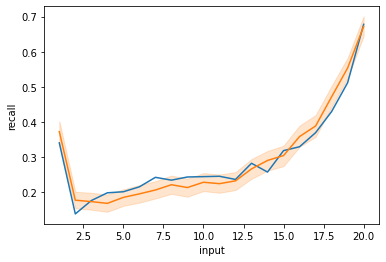

In [5]:
plt.plot(np.arange(20)+1, fast_spc(sim_array, murd_length0))
plot_spc(sim_df)

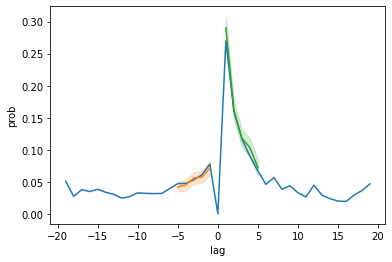

In [10]:
plt.plot(np.arange(-murd_length0+1, murd_length0), fast_crp(sim_array, murd_length0))
plot_lag_crp(sim_df)

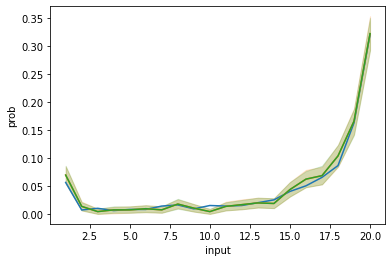

In [11]:
plt.plot(np.arange(20)+1, fast_pfr(sim_array, murd_length0))
plot_pfr(sim_df)

### MSE

In [12]:
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

murdock_mse((murd_trials0, ), (20, ), (fast_spc, ), init_cmr, fitted_parameters)

0.006200364824459877

In [13]:
murdock_mse((sim_array, ), (20, ), (fast_spc, ), init_cmr, fitted_parameters)

0.000305675

In [14]:
murdock_mse((sim_array, ), (20, ), (fast_crp, ), init_cmr, fitted_parameters)

3.825651611228808e-05

full crp: 3.263360510384407e-05

In [15]:
murdock_mse((murd_trials0, ), (20, ), (fast_spc, fast_crp), init_cmr, fitted_parameters)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


0.003580339173768508

In [16]:
murdock_mse((murd_trials0, ), (20, ), (fast_csp, ), init_cmr, fitted_parameters)

0.055944766113111645

## PFR Fitting

In [17]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_pfr, ),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

differential_evolution step 1: f(x)= 0.00154887
differential_evolution step 2: f(x)= 0.00122679
differential_evolution step 3: f(x)= 0.000927215
differential_evolution step 4: f(x)= 0.000927215
differential_evolution step 5: f(x)= 0.000927215
differential_evolution step 6: f(x)= 0.000927215
differential_evolution step 7: f(x)= 0.000927215
differential_evolution step 8: f(x)= 0.000927215
differential_evolution step 9: f(x)= 0.000927215
differential_evolution step 10: f(x)= 0.000927215
differential_evolution step 11: f(x)= 0.000927215
differential_evolution step 12: f(x)= 0.000927215
differential_evolution step 13: f(x)= 0.000722264
differential_evolution step 14: f(x)= 0.000722264
differential_evolution step 15: f(x)= 0.000527025
differential_evolution step 16: f(x)= 0.000475793
differential_evolution step 17: f(x)= 0.00046278
differential_evolution step 18: f(x)= 0.00046278
differential_evolution step 19: f(x)= 0.00046278
differential_evolution step 20: f(x)= 0.00046278
differential_ev

In [18]:
#| include: false
print(cmr_result)

     fun: 0.0004255495273919753
 message: 'Optimization terminated successfully.'
    nfev: 5673
     nit: 29
 success: True
       x: array([3.61289435e-01, 8.05827822e-02, 5.08075299e-01, 2.89868542e-01,
       3.49512351e-01, 7.52929232e-01, 1.35882729e+00, 1.43563527e+01,
       5.84811614e-03, 3.15417711e+00, 9.78376540e+00, 3.22460572e-01])


In [19]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_df(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_csp = fast_csp(simulate_array(model, 1000), murd_length0)
sim_csp[sim_csp == 0] = np.nan

true_csp = fast_csp(murd_trials0, murd_length0)
true_csp[true_csp == 0] = np.nan

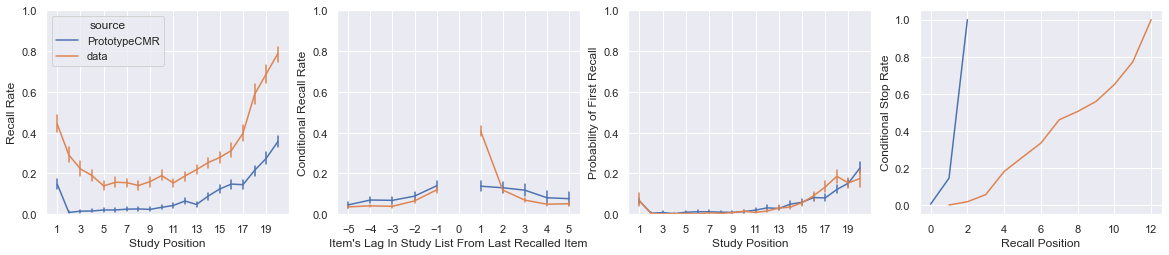

In [20]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(ax=axes[2], data=cmr_pfr, x='input', y='prob', err_style='bars', hue='source', legend=False)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# stop probability
axes[3].plot(np.arange(murd_length0+1), sim_csp, label='PrototypeCMR')
axes[3].plot(np.arange(murd_length0+1), true_csp, label='data')
axes[3].set(xlabel='Recall Position', ylabel='Conditional Stop Rate')
#axes[1, 1].set_xticks(np.arange(1, 21, 2))

# set legend of final axis outside the plot, to the right
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout(pad=0)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## SPC Fitting

In [21]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_spc, ),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

differential_evolution step 1: f(x)= 0.0447643
differential_evolution step 2: f(x)= 0.0254814
differential_evolution step 3: f(x)= 0.0181923
differential_evolution step 4: f(x)= 0.0181923
differential_evolution step 5: f(x)= 0.0181923
differential_evolution step 6: f(x)= 0.0163455
differential_evolution step 7: f(x)= 0.0163455
differential_evolution step 8: f(x)= 0.0163455
differential_evolution step 9: f(x)= 0.0163455
differential_evolution step 10: f(x)= 0.0113636
differential_evolution step 11: f(x)= 0.00883448
differential_evolution step 12: f(x)= 0.00592007
differential_evolution step 13: f(x)= 0.00592007
differential_evolution step 14: f(x)= 0.00592007
differential_evolution step 15: f(x)= 0.00592007
differential_evolution step 16: f(x)= 0.00566654
differential_evolution step 17: f(x)= 0.0035056
differential_evolution step 18: f(x)= 0.0035056
differential_evolution step 19: f(x)= 0.00350265
differential_evolution step 20: f(x)= 0.00312214
differential_evolution step 21: f(x)= 0.0

In [22]:
#| include: false
print(cmr_result)

     fun: 0.0007045365547839508
 message: 'Optimization terminated successfully.'
    nfev: 19112
     nit: 102
 success: True
       x: array([8.54624273e-01, 1.24998011e-01, 4.72319147e-01, 1.78755837e-02,
       8.17183557e-01, 2.05224584e-01, 4.58714666e+00, 6.01115185e+01,
       1.77370602e-02, 4.48216549e-01, 8.77821706e-01, 7.72150019e-02])


In [23]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_csp = fast_csp(simulate_array(model, 1000), murd_length0)
sim_csp[sim_csp == 0] = np.nan

true_csp = fast_csp(murd_trials0, murd_length0)
true_csp[true_csp == 0] = np.nan

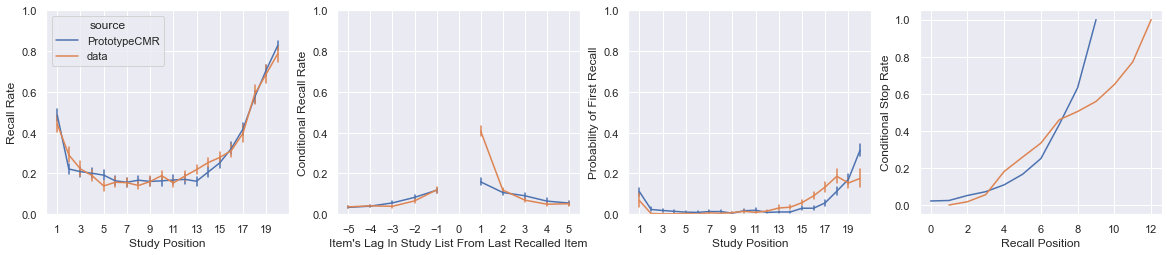

In [24]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(ax=axes[2], data=cmr_pfr, x='input', y='prob', err_style='bars', hue='source', legend=False)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# stop probability
axes[3].plot(np.arange(murd_length0+1), sim_csp, label='PrototypeCMR')
axes[3].plot(np.arange(murd_length0+1), true_csp, label='data')
axes[3].set(xlabel='Recall Position', ylabel='Conditional Stop Rate')
#axes[1, 1].set_xticks(np.arange(1, 21, 2))

# set legend of final axis outside the plot, to the right
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout(pad=0)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## CRP Fitting

In [25]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_crp, ),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

differential_evolution step 1: f(x)= 0.00162505
differential_evolution step 2: f(x)= 0.00129585
differential_evolution step 3: f(x)= 0.000798374
differential_evolution step 4: f(x)= 0.000798374
differential_evolution step 5: f(x)= 0.000647531
differential_evolution step 6: f(x)= 0.000647531
differential_evolution step 7: f(x)= 0.000647531
differential_evolution step 8: f(x)= 0.000647531
differential_evolution step 9: f(x)= 0.000647531
differential_evolution step 10: f(x)= 0.000647531
differential_evolution step 11: f(x)= 0.000606449
differential_evolution step 12: f(x)= 0.000405153
differential_evolution step 13: f(x)= 0.000340931
differential_evolution step 14: f(x)= 0.000340931
differential_evolution step 15: f(x)= 0.000340931
differential_evolution step 16: f(x)= 0.000340931
differential_evolution step 17: f(x)= 0.000340931
differential_evolution step 18: f(x)= 0.000340931
differential_evolution step 19: f(x)= 0.000340931
differential_evolution step 20: f(x)= 0.000340931
differentia

In [26]:
#| include: false
print(cmr_result)

     fun: 0.0003409306950577844
 message: 'Optimization terminated successfully.'
    nfev: 5172
     nit: 26
 success: True
       x: array([7.61798729e-01, 5.58515987e-02, 9.91564193e-01, 5.21528698e-01,
       9.08454316e-01, 3.74735219e-01, 4.93996080e+01, 4.07889029e+01,
       2.14875881e-02, 3.11290305e-01, 6.15566127e+00, 5.44423246e-01])


In [27]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_csp = fast_csp(simulate_array(model, 1000), murd_length0)
sim_csp[sim_csp == 0] = np.nan

true_csp = fast_csp(murd_trials0, murd_length0)
true_csp[true_csp == 0] = np.nan

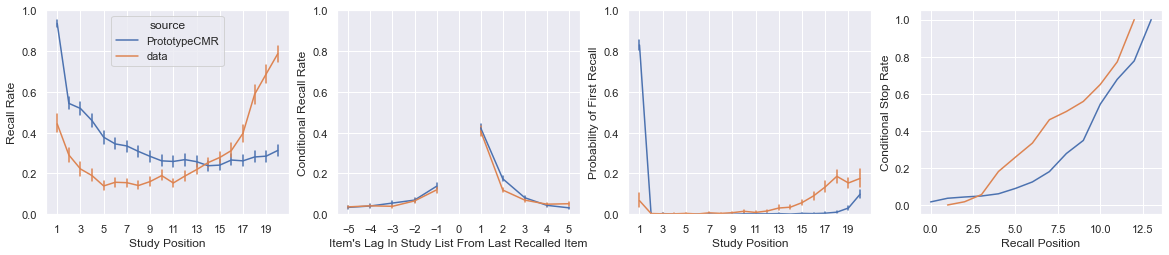

In [28]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(ax=axes[2], data=cmr_pfr, x='input', y='prob', err_style='bars', hue='source', legend=False)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# stop probability
axes[3].plot(np.arange(murd_length0+1), sim_csp, label='PrototypeCMR')
axes[3].plot(np.arange(murd_length0+1), true_csp, label='data')
axes[3].set(xlabel='Recall Position', ylabel='Conditional Stop Rate')
#axes[1, 1].set_xticks(np.arange(1, 21, 2))

# set legend of final axis outside the plot, to the right
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout(pad=0)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## CSP Fitting

In [30]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_csp, ),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

differential_evolution step 1: f(x)= 0.113868
differential_evolution step 2: f(x)= 0.113868
differential_evolution step 3: f(x)= 0.00667879
differential_evolution step 4: f(x)= 0.00667879
differential_evolution step 5: f(x)= 0.00667879
differential_evolution step 6: f(x)= 0.00667879
differential_evolution step 7: f(x)= 0.00667879
differential_evolution step 8: f(x)= 0.00339166
differential_evolution step 9: f(x)= 0.00313329
differential_evolution step 10: f(x)= 0.00271222
differential_evolution step 11: f(x)= 0.00271222
differential_evolution step 12: f(x)= 0.00271222
differential_evolution step 13: f(x)= 0.00271222
differential_evolution step 14: f(x)= 0.00271222
differential_evolution step 15: f(x)= 0.00271222
differential_evolution step 16: f(x)= 0.00271222
differential_evolution step 17: f(x)= 0.00271222
differential_evolution step 18: f(x)= 0.00267846
differential_evolution step 19: f(x)= 0.00267846
differential_evolution step 20: f(x)= 0.00251255
differential_evolution step 21: f

In [31]:
#| include: false
print(cmr_result)

     fun: 0.002335862288791434
 message: 'Optimization terminated successfully.'
    nfev: 5738
     nit: 29
 success: True
       x: array([5.20217554e-01, 3.55964509e-01, 5.02135713e-01, 5.52293276e-01,
       8.67049977e-01, 3.37086511e-01, 3.83487268e+01, 7.89966433e+01,
       7.61945773e-02, 2.17170674e-01, 3.09838038e+00, 7.11030392e-01])


In [32]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_csp = fast_csp(simulate_array(model, 1000), murd_length0)
sim_csp[sim_csp == 0] = np.nan

true_csp = fast_csp(murd_trials0, murd_length0)
true_csp[true_csp == 0] = np.nan

[Text(0.5, 0, 'Recall Position'), Text(0, 0.5, 'Conditional Stop Rate')]

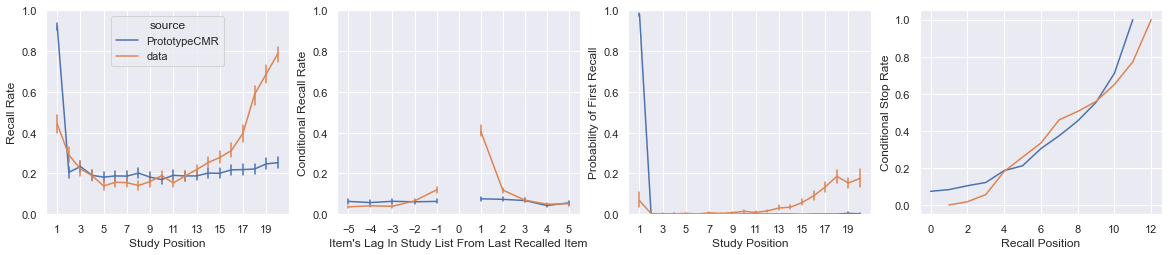

In [33]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(ax=axes[2], data=cmr_pfr, x='input', y='prob', err_style='bars', hue='source', legend=False)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# stop probability
axes[3].plot(np.arange(murd_length0+1), sim_csp, label='PrototypeCMR')
axes[3].plot(np.arange(murd_length0+1), true_csp, label='data')
axes[3].set(xlabel='Recall Position', ylabel='Conditional Stop Rate')
#axes[1, 1].set_xticks(np.arange(1, 21, 2))

# set legend of final axis outside the plot, to the right
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout(pad=0)plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## PFR + SPC Fitting

In [34]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_pfr, fast_spc),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


differential_evolution step 1: f(x)= 0.0284284
differential_evolution step 2: f(x)= 0.0242994
differential_evolution step 3: f(x)= 0.0242994
differential_evolution step 4: f(x)= 0.0242994
differential_evolution step 5: f(x)= 0.0233288
differential_evolution step 6: f(x)= 0.0233288
differential_evolution step 7: f(x)= 0.0180375
differential_evolution step 8: f(x)= 0.00641113
differential_evolution step 9: f(x)= 0.00641113
differential_evolution step 10: f(x)= 0.00641113
differential_evolution step 11: f(x)= 0.00641113
differential_evolution step 12: f(x)= 0.00641113
differential_evolution step 13: f(x)= 0.00641113
differential_evolution step 14: f(x)= 0.00641113
differential_evolution step 15: f(x)= 0.00641113
differential_evolution step 16: f(x)= 0.00641113
differential_evolution step 17: f(x)= 0.00641113
differential_evolution step 18: f(x)= 0.00370231
differential_evolution step 19: f(x)= 0.00273508
differential_evolution step 20: f(x)= 0.00273508
differential_evolution step 21: f(x)

In [35]:
#| include: false
print(cmr_result)

     fun: 0.001155065706983025
 message: 'Optimization terminated successfully.'
    nfev: 14918
     nit: 80
 success: True
       x: array([5.92976793e-01, 6.34605701e-02, 1.65110581e-02, 2.70986649e-01,
       5.98038717e-01, 1.25047435e-01, 8.11471628e+00, 1.21589613e+00,
       1.34190561e-03, 1.01160938e+00, 2.65060304e+00, 1.74234603e-01])


In [36]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_csp = fast_csp(simulate_array(model, 1000), murd_length0)
sim_csp[sim_csp == 0] = np.nan

true_csp = fast_csp(murd_trials0, murd_length0)
true_csp[true_csp == 0] = np.nan

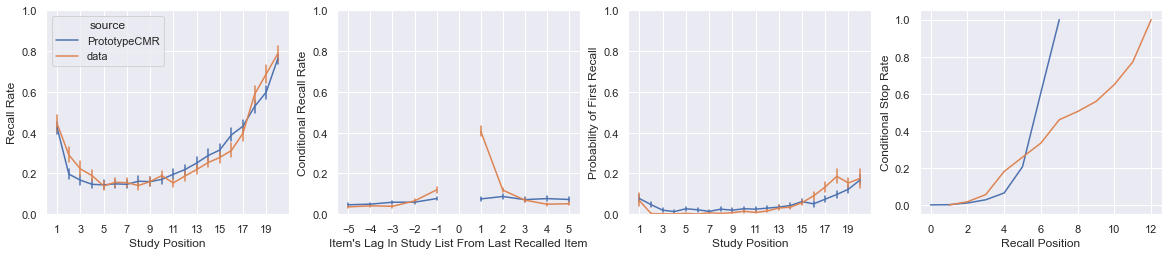

In [37]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(ax=axes[2], data=cmr_pfr, x='input', y='prob', err_style='bars', hue='source', legend=False)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# stop probability
axes[3].plot(np.arange(murd_length0+1), sim_csp, label='PrototypeCMR')
axes[3].plot(np.arange(murd_length0+1), true_csp, label='data')
axes[3].set(xlabel='Recall Position', ylabel='Conditional Stop Rate')
#axes[1, 1].set_xticks(np.arange(1, 21, 2))

# set legend of final axis outside the plot, to the right
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout(pad=0)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## PFR + CRP Fitting

In [38]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_pfr, fast_crp),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


differential_evolution step 1: f(x)= 0.00364896
differential_evolution step 2: f(x)= 0.00332692
differential_evolution step 3: f(x)= 0.00330161
differential_evolution step 4: f(x)= 0.00293594
differential_evolution step 5: f(x)= 0.00250113
differential_evolution step 6: f(x)= 0.00250113
differential_evolution step 7: f(x)= 0.00250113
differential_evolution step 8: f(x)= 0.00207135
differential_evolution step 9: f(x)= 0.00207135
differential_evolution step 10: f(x)= 0.00207135
differential_evolution step 11: f(x)= 0.00207135
differential_evolution step 12: f(x)= 0.0019607
differential_evolution step 13: f(x)= 0.00183256
differential_evolution step 14: f(x)= 0.00183256
differential_evolution step 15: f(x)= 0.00183256
differential_evolution step 16: f(x)= 0.00154633
differential_evolution step 17: f(x)= 0.00154633
differential_evolution step 18: f(x)= 0.00154633
differential_evolution step 19: f(x)= 0.00154633
differential_evolution step 20: f(x)= 0.00154633
differential_evolution step 21

In [39]:
#| include: false
print(cmr_result)

     fun: 0.0007646284464991045
 message: 'Optimization terminated successfully.'
    nfev: 8208
     nit: 42
 success: True
       x: array([4.67869338e-01, 1.74913967e-02, 9.25945061e-01, 3.07041389e-01,
       1.05615962e-01, 1.47742423e-01, 4.13516762e+00, 3.86148249e+01,
       2.46912169e-02, 1.48821380e+00, 7.09248388e+00, 5.97116943e-01])


In [40]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_csp = fast_csp(simulate_array(model, 1000), murd_length0)
sim_csp[sim_csp == 0] = np.nan

true_csp = fast_csp(murd_trials0, murd_length0)
true_csp[true_csp == 0] = np.nan

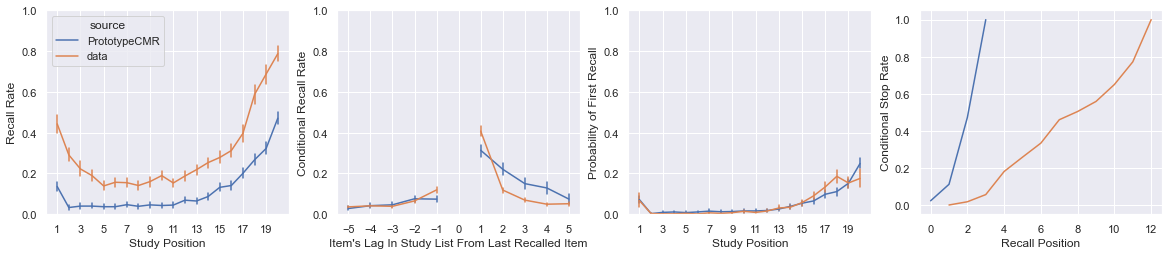

In [41]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(ax=axes[2], data=cmr_pfr, x='input', y='prob', err_style='bars', hue='source', legend=False)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# stop probability
axes[3].plot(np.arange(murd_length0+1), sim_csp, label='PrototypeCMR')
axes[3].plot(np.arange(murd_length0+1), true_csp, label='data')
axes[3].set(xlabel='Recall Position', ylabel='Conditional Stop Rate')
#axes[1, 1].set_xticks(np.arange(1, 21, 2))

# set legend of final axis outside the plot, to the right
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout(pad=0)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## SPC + CRP Fitting

In [42]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_crp, fast_spc),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


differential_evolution step 1: f(x)= 0.0166766
differential_evolution step 2: f(x)= 0.0166766
differential_evolution step 3: f(x)= 0.0166766
differential_evolution step 4: f(x)= 0.0157798
differential_evolution step 5: f(x)= 0.0157798
differential_evolution step 6: f(x)= 0.0157798
differential_evolution step 7: f(x)= 0.0123521
differential_evolution step 8: f(x)= 0.0123521
differential_evolution step 9: f(x)= 0.0123477
differential_evolution step 10: f(x)= 0.0123477
differential_evolution step 11: f(x)= 0.0110269
differential_evolution step 12: f(x)= 0.0110269
differential_evolution step 13: f(x)= 0.0110269
differential_evolution step 14: f(x)= 0.00709272
differential_evolution step 15: f(x)= 0.00709272
differential_evolution step 16: f(x)= 0.00709272
differential_evolution step 17: f(x)= 0.00473991
differential_evolution step 18: f(x)= 0.00473991
differential_evolution step 19: f(x)= 0.00473991
differential_evolution step 20: f(x)= 0.00385158
differential_evolution step 21: f(x)= 0.00

In [43]:
#| include: false
print(cmr_result)

     fun: 0.0008803012675522226
 message: 'Optimization terminated successfully.'
    nfev: 14493
     nit: 78
 success: True
       x: array([6.54368377e-01, 1.91349924e-02, 9.47171584e-01, 5.08397179e-01,
       6.75251837e-01, 3.00014171e-01, 1.68703979e+01, 5.11237327e+01,
       2.28382477e-02, 3.85682889e-01, 8.81683741e+00, 1.91235053e-01])


In [44]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_csp = fast_csp(simulate_array(model, 1000), murd_length0)
sim_csp[sim_csp == 0] = np.nan

true_csp = fast_csp(murd_trials0, murd_length0)
true_csp[true_csp == 0] = np.nan

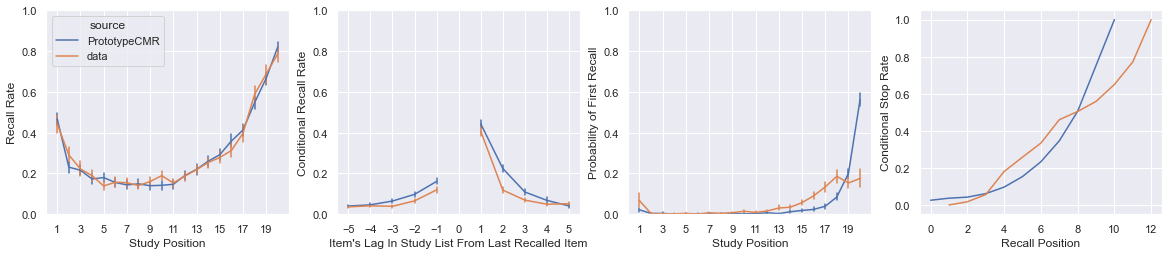

In [45]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(ax=axes[2], data=cmr_pfr, x='input', y='prob', err_style='bars', hue='source', legend=False)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# stop probability
axes[3].plot(np.arange(murd_length0+1), sim_csp, label='PrototypeCMR')
axes[3].plot(np.arange(murd_length0+1), true_csp, label='data')
axes[3].set(xlabel='Recall Position', ylabel='Conditional Stop Rate')
#axes[1, 1].set_xticks(np.arange(1, 21, 2))

# set legend of final axis outside the plot, to the right
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout(pad=0)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## PFR + CRP + CSP Fitting

In [46]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_pfr, fast_csp, fast_crp),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


differential_evolution step 1: f(x)= 0.032872
differential_evolution step 2: f(x)= 0.017015
differential_evolution step 3: f(x)= 0.017015
differential_evolution step 4: f(x)= 0.00577805
differential_evolution step 5: f(x)= 0.00577805
differential_evolution step 6: f(x)= 0.00577805
differential_evolution step 7: f(x)= 0.00577805
differential_evolution step 8: f(x)= 0.00577805
differential_evolution step 9: f(x)= 0.00577805
differential_evolution step 10: f(x)= 0.00577805
differential_evolution step 11: f(x)= 0.00577805
differential_evolution step 12: f(x)= 0.00465495
differential_evolution step 13: f(x)= 0.00380615
differential_evolution step 14: f(x)= 0.00380615
differential_evolution step 15: f(x)= 0.00348904
differential_evolution step 16: f(x)= 0.00348904
differential_evolution step 17: f(x)= 0.00348904
differential_evolution step 18: f(x)= 0.00348904
differential_evolution step 19: f(x)= 0.00348904
differential_evolution step 20: f(x)= 0.0034668
differential_evolution step 21: f(x)

In [47]:
#| include: false
print(cmr_result)

     fun: 0.0015578087136556042
     jac: array([ 7011.73165698,  5396.26268652,  5080.55469041, -5443.19330658,
        6413.91622778, -4136.55040124,  5016.2463243 ,  3315.43675262,
        8283.08857908, -4009.7817692 , 10060.30234243, -1059.95314022])
 message: 'Optimization terminated successfully.'
    nfev: 12771
     nit: 68
 success: True
       x: array([3.91140434e-01, 1.47956835e-02, 9.44239955e-01, 3.65846233e-01,
       7.33564320e-01, 5.84242414e-02, 1.67829386e+00, 7.83781075e+01,
       8.14997044e-02, 2.11683707e-01, 8.54137684e+00, 6.08314675e-01])


In [48]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_csp = fast_csp(simulate_array(model, 1000), murd_length0)
sim_csp[sim_csp == 0] = np.nan

true_csp = fast_csp(murd_trials0, murd_length0)
true_csp[true_csp == 0] = np.nan

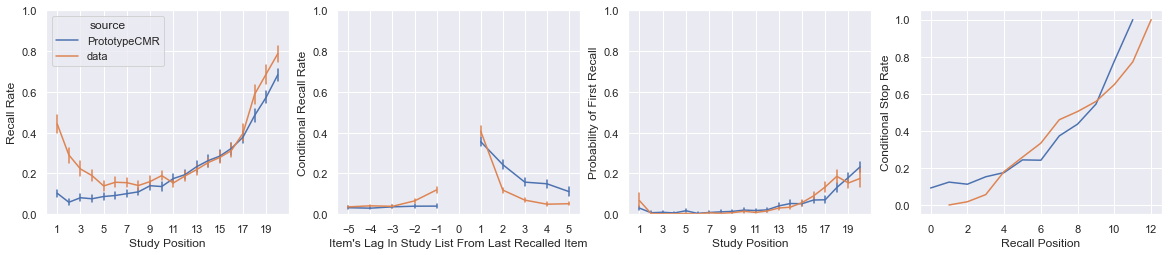

In [49]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(ax=axes[2], data=cmr_pfr, x='input', y='prob', err_style='bars', hue='source', legend=False)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# stop probability
axes[3].plot(np.arange(murd_length0+1), sim_csp, label='PrototypeCMR')
axes[3].plot(np.arange(murd_length0+1), true_csp, label='data')
axes[3].set(xlabel='Recall Position', ylabel='Conditional Stop Rate')
#axes[1, 1].set_xticks(np.arange(1, 21, 2))

# set legend of final axis outside the plot, to the right
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout(pad=0)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

## PFR + SPC + CRP Fitting

In [50]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cost_function = murdock_mse_objective_function(
    (murd_trials0, ),
    (murd_length0, ),
    (fast_pfr, fast_spc, fast_crp),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0005)

C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
C:\Users\gunnj\AppData\Local\Temp/ipykernel_23624/1255760522.py:17: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for statistic in literal_unroll(statistics):
c:\programdata\miniconda3\lib\site-packages\numba\core\untyped_passes.py:1321: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  return range(len(a))


differential_evolution step 1: f(x)= 0.0199438
differential_evolution step 2: f(x)= 0.0199438
differential_evolution step 3: f(x)= 0.015701
differential_evolution step 4: f(x)= 0.0109934
differential_evolution step 5: f(x)= 0.0109934
differential_evolution step 6: f(x)= 0.010723
differential_evolution step 7: f(x)= 0.010723
differential_evolution step 8: f(x)= 0.00733043
differential_evolution step 9: f(x)= 0.00733043
differential_evolution step 10: f(x)= 0.00733043
differential_evolution step 11: f(x)= 0.00622395
differential_evolution step 12: f(x)= 0.00622395
differential_evolution step 13: f(x)= 0.00622395
differential_evolution step 14: f(x)= 0.00551385
differential_evolution step 15: f(x)= 0.00551385
differential_evolution step 16: f(x)= 0.00409678
differential_evolution step 17: f(x)= 0.00409678
differential_evolution step 18: f(x)= 0.00409678
differential_evolution step 19: f(x)= 0.00409678
differential_evolution step 20: f(x)= 0.00385932
differential_evolution step 21: f(x)= 0

In [51]:
#| include: false
print(cmr_result)

     fun: 0.001694343964907151
 message: 'Optimization terminated successfully.'
    nfev: 14519
     nit: 78
 success: True
       x: array([ 0.50846892,  0.2234063 ,  0.54089557,  0.28745385,  0.26236087,
        0.0768098 ,  0.97706408, 13.06280187,  0.01811385,  0.48291944,
        7.94585821,  0.87180647])


In [52]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
sim_csp = fast_csp(simulate_array(model, 1000), murd_length0)
sim_csp[sim_csp == 0] = np.nan

true_csp = fast_csp(murd_trials0, murd_length0)
true_csp[true_csp == 0] = np.nan

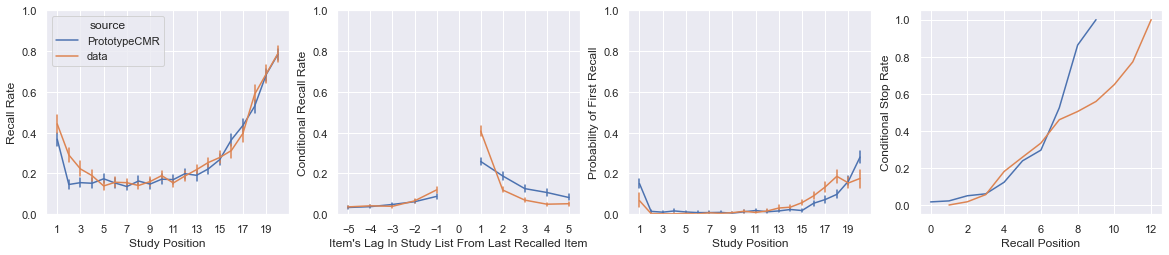

In [53]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 15/4), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(ax=axes[2], data=cmr_pfr, x='input', y='prob', err_style='bars', hue='source', legend=False)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

# stop probability
axes[3].plot(np.arange(murd_length0+1), sim_csp, label='PrototypeCMR')
axes[3].plot(np.arange(murd_length0+1), true_csp, label='data')
axes[3].set(xlabel='Recall Position', ylabel='Conditional Stop Rate')
#axes[1, 1].set_xticks(np.arange(1, 21, 2))

# set legend of final axis outside the plot, to the right
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#axes[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout(pad=0)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')